# HR Attrition Analysis & Turnover Prediction (Improved)

This notebook is a **clean, end-to-end** HR attrition analysis using the classic `HR_comma_sep.csv` dataset.

It is designed to be:
- **Reproducible** (fixed random seed, train/test split, cross-validation)
- **Leakage-aware** (duplicate handling, no peeking at test data during training/tuning)
- **Actionable** (segment analysis + interpretable model outputs)

## What you’ll get
1. Data audit (schema, duplicates, missing values)
2. Exploratory data analysis (EDA) focused on drivers of `left`
3. Feature engineering (lightweight, explainable)
4. Model comparison (baseline → Logistic Regression → Tree-based models)
5. Evaluation with metrics that matter for attrition (ROC-AUC, PR-AUC, confusion matrix)
6. Interpretability (permutation importance + partial dependence)

> **Target**: `left` (1 = employee left, 0 = employee stayed)


In [1]:
# If you're running this notebook in a fresh environment and are missing packages,
# uncomment the next lines.
# %pip install -U pandas numpy matplotlib seaborn scikit-learn xgboost

from __future__ import annotations

from pathlib import Path
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Performance toggle:
# - FAST_MODE=True runs quicker (fewer CV folds / fewer trees / fewer permutation repeats)
# - Set FAST_MODE=False for more robust estimates (but slower)
FAST_MODE = True

N_SPLITS = 3 if FAST_MODE else 5
RF_TREES = 250 if FAST_MODE else 700
XGB_TREES = 350 if FAST_MODE else 900
PERM_REPEATS = 7 if FAST_MODE else 20

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

print("pandas:", pd.__version__)
print("FAST_MODE:", FAST_MODE, "| CV folds:", N_SPLITS)


pandas: 2.3.3
FAST_MODE: True | CV folds: 3


In [2]:
# Load data
DATA_PATH = Path("HR_comma_sep.csv")

if not DATA_PATH.exists():
    # fallback: search recursively (useful if notebook is moved)
    candidates = list(Path(".").rglob("HR_comma_sep.csv"))
    if candidates:
        DATA_PATH = candidates[0]
    else:
        raise FileNotFoundError(
            "Could not find HR_comma_sep.csv. "
            "Place it next to this notebook or update DATA_PATH."
        )

df_raw = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH.resolve())
print("Shape:", df_raw.shape)

display(df_raw.head())


Loaded: /Users/mustafasen/Desktop/HR_Data_Analysis/HR_comma_sep.csv
Shape: (14999, 10)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
# Quick audit
display(df_raw.sample(5, random_state=RANDOM_STATE))

print("\nColumns:")
print(df_raw.columns.tolist())

print("\nInfo:")
df_raw.info()

print("\nMissing values per column:")
display(df_raw.isna().sum().to_frame("missing_count"))


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
6723,0.65,0.96,5,226,2,1,0,0,marketing,medium
6473,0.88,0.80,3,166,2,0,0,0,IT,low
4679,0.69,0.98,3,214,2,0,0,0,sales,low
862,0.41,0.47,2,154,3,0,1,0,sales,low
7286,0.87,0.76,5,254,2,1,0,0,hr,low



Columns:
['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'left', 'promotion_last_5years', 'sales', 'salary']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB

Missing valu

,missing_count
satisfaction_level,0
last_evaluation,0
number_project,0
average_montly_hours,0
time_spend_company,0
Work_accident,0
left,0
promotion_last_5years,0
sales,0
salary,0


In [4]:
# Cleaning + light feature engineering
df = df_raw.copy()

# Fix known naming issues
df = df.rename(columns={
    "sales": "department",
    "average_montly_hours": "average_monthly_hours",
})

# Standardize categorical dtypes
df["department"] = df["department"].astype("category")
df["salary"] = pd.Categorical(df["salary"], categories=["low", "medium", "high"], ordered=True)

# Basic checks
assert set(["left", "department", "salary"]).issubset(df.columns), "Expected core columns missing."

# Duplicates matter for modeling because they can leak patterns into both train and test splits.
dup_count = df.duplicated().sum()
print(f"Exact duplicate rows: {dup_count:,} ({dup_count/len(df):.1%})")

df_nodup = df.drop_duplicates().reset_index(drop=True)
print("Shape without exact duplicates:", df_nodup.shape)

# Ordinal encode salary for modeling (keeps ordering information)
df_nodup["salary_ordinal"] = df_nodup["salary"].cat.codes.astype("int8")

# Explainable derived features (simple flags that often matter in retention conversations)
df_nodup["overworked"] = (df_nodup["average_monthly_hours"] >= 250).astype("int8")   # ~50+ hrs/week if ~4 wks/month
df_nodup["underworked"] = (df_nodup["average_monthly_hours"] <= 150).astype("int8")
df_nodup["high_projects"] = (df_nodup["number_project"] >= 6).astype("int8")
df_nodup["low_projects"]  = (df_nodup["number_project"] <= 2).astype("int8")
df_nodup["long_tenure"]   = (df_nodup["time_spend_company"] >= 5).astype("int8")

display(df_nodup.head())


Exact duplicate rows: 3,008 (20.1%)
Shape without exact duplicates: (11991, 10)


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary,salary_ordinal,overworked,underworked,high_projects,low_projects,long_tenure
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,1,1,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,1,1,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,sales,low,0,0,0,0,0,1
4,0.37,0.52,2,159,3,0,1,0,sales,low,0,0,0,0,1,0


## EDA: How common is attrition?

Before any modeling, it’s useful to understand:
- The overall attrition rate (baseline)
- Which groups (department, salary) have higher rates
- Whether numeric features show clear separation between those who left vs stayed

> **Note**: This dataset is widely used for learning. Some relationships can be unusually “clean” compared to real HR data.


Overall attrition rate: 23.81%


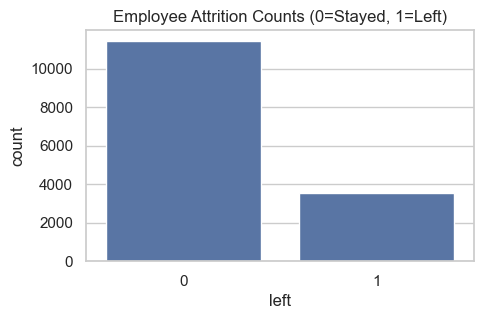

In [5]:
# Attrition rate (baseline)
attrition_rate = df["left"].mean()
print(f"Overall attrition rate: {attrition_rate:.2%}")

plt.figure(figsize=(5, 3))
ax = sns.countplot(data=df, x="left")
ax.set_title("Employee Attrition Counts (0=Stayed, 1=Left)")
ax.set_xlabel("left")
ax.set_ylabel("count")
plt.show()


In [8]:
#%pip install jinja2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [jinja2]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


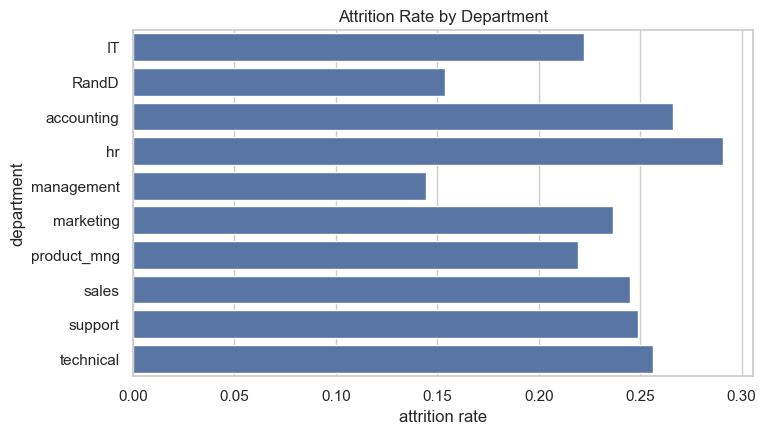

,attrition_rate
department,
management,14.44%
RandD,15.37%
product_mng,21.95%
IT,22.25%
marketing,23.66%
sales,24.49%
support,24.90%
technical,25.62%
accounting,26.60%


In [9]:
# Attrition by department (rate)
dept_rate = (
    df.groupby("department")["left"]
      .mean()
      .sort_values()
)

plt.figure(figsize=(8, 4.5))
ax = sns.barplot(x=dept_rate.values, y=dept_rate.index)
ax.set_title("Attrition Rate by Department")
ax.set_xlabel("attrition rate")
ax.set_ylabel("department")
plt.show()

display(dept_rate.to_frame("attrition_rate").style.format({"attrition_rate": "{:.2%}"}))


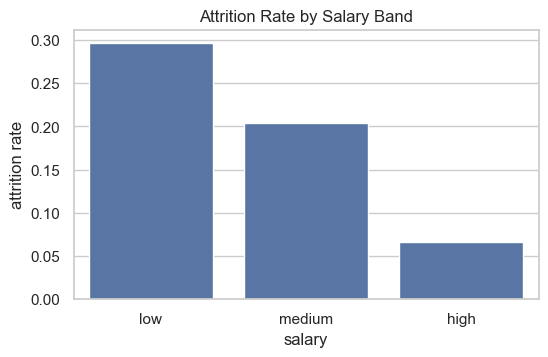

,attrition_rate
salary,
low,29.69%
medium,20.43%
high,6.63%


In [10]:
# Attrition by salary (rate)
sal_rate = df.groupby("salary")["left"].mean()

plt.figure(figsize=(6, 3.5))
ax = sns.barplot(x=sal_rate.index.astype(str), y=sal_rate.values)
ax.set_title("Attrition Rate by Salary Band")
ax.set_xlabel("salary")
ax.set_ylabel("attrition rate")
plt.show()

display(sal_rate.to_frame("attrition_rate").style.format({"attrition_rate": "{:.2%}"}))


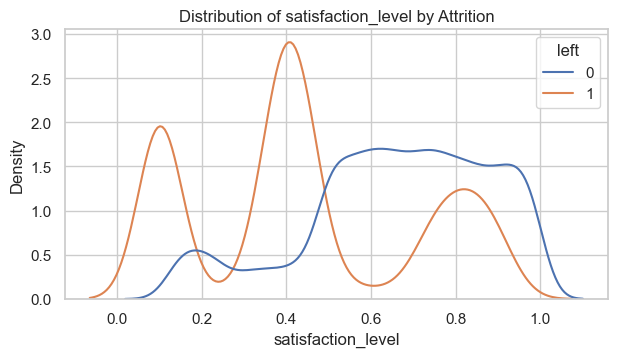

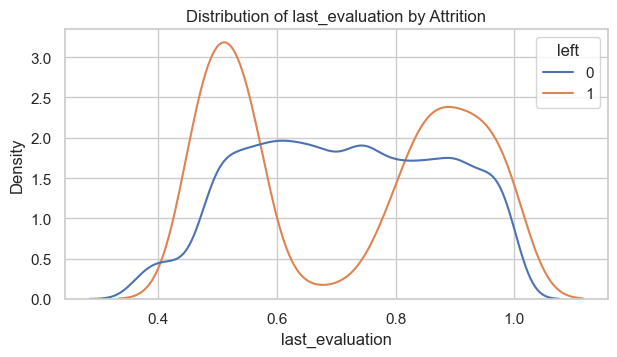

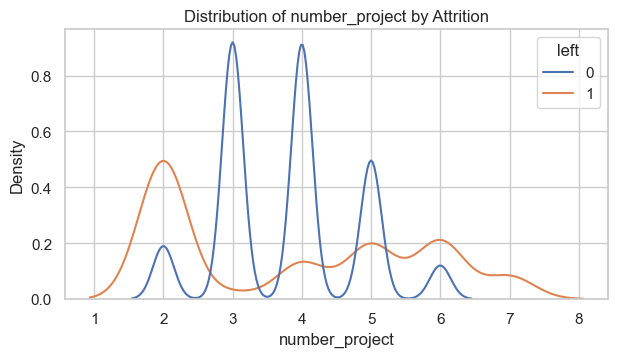

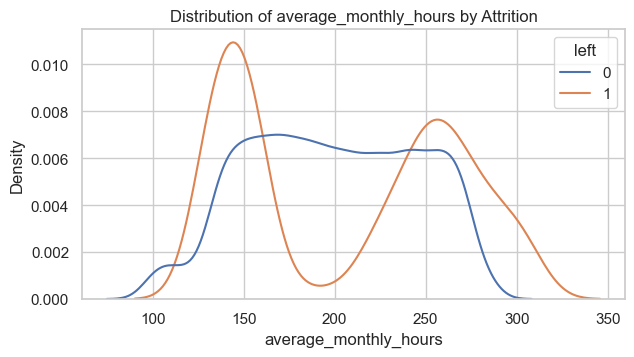

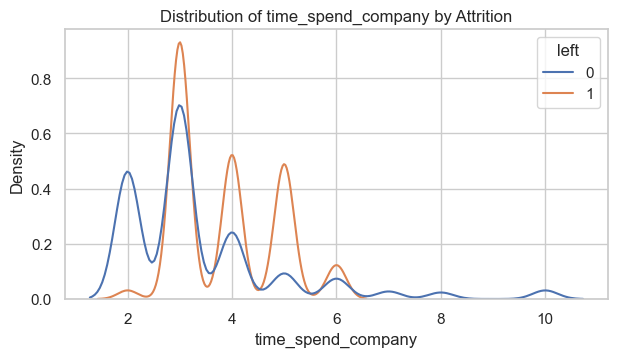

In [11]:
# Numeric feature distributions by attrition
num_cols = [
    "satisfaction_level",
    "last_evaluation",
    "number_project",
    "average_monthly_hours",
    "time_spend_company",
]

for col in num_cols:
    plt.figure(figsize=(7, 3.5))
    sns.kdeplot(data=df, x=col, hue="left", common_norm=False)
    plt.title(f"Distribution of {col} by Attrition")
    plt.show()


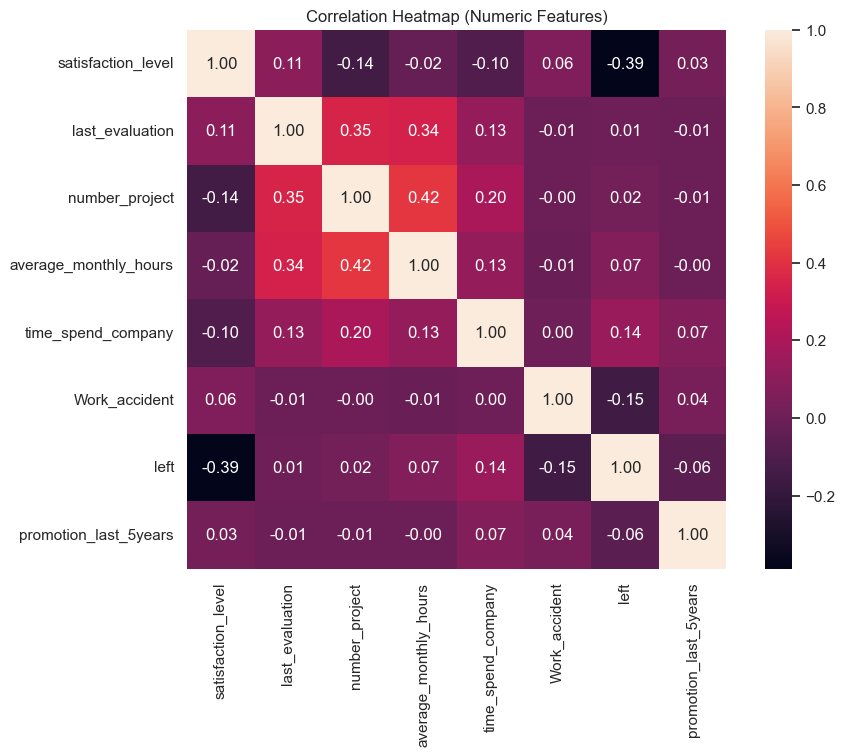

In [12]:
# Correlation heatmap (numeric features only)
num_df = df.select_dtypes(include="number").copy()

plt.figure(figsize=(10, 7))
corr = num_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", square=True)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


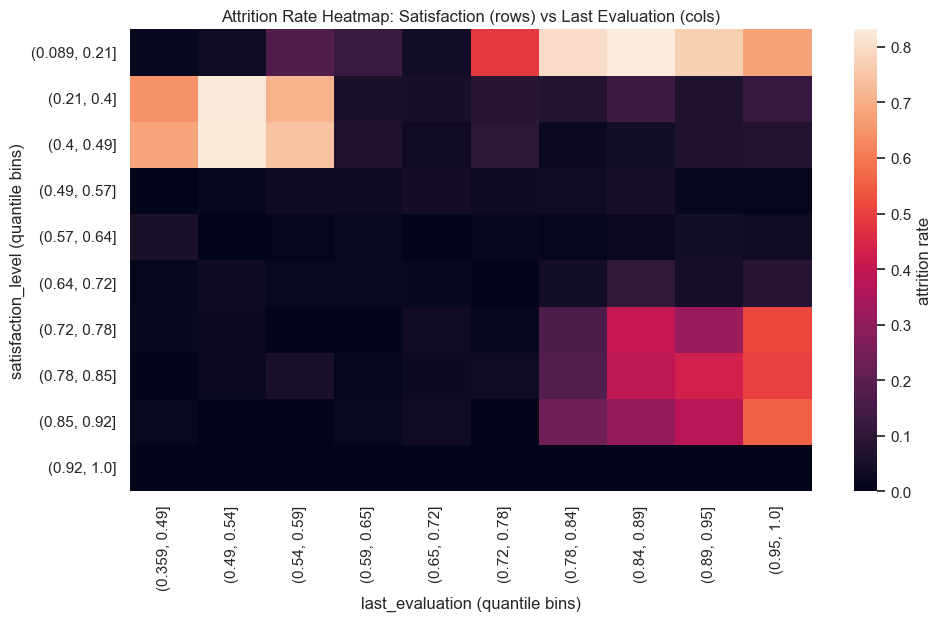

In [13]:
# Attrition rate heatmap: Satisfaction vs Last Evaluation
# Using quantile bins makes counts per bin more stable than fixed-width bins.
sat_bin = pd.qcut(df["satisfaction_level"], q=10, duplicates="drop")
eval_bin = pd.qcut(df["last_evaluation"], q=10, duplicates="drop")

pivot = df.pivot_table(index=sat_bin, columns=eval_bin, values="left", aggfunc="mean")

plt.figure(figsize=(11, 6))
sns.heatmap(pivot, annot=False, cbar_kws={"label": "attrition rate"})
plt.title("Attrition Rate Heatmap: Satisfaction (rows) vs Last Evaluation (cols)")
plt.xlabel("last_evaluation (quantile bins)")
plt.ylabel("satisfaction_level (quantile bins)")
plt.show()


,mean,median,count
number_project,,,
2,160.342546,149.0,2388
3,197.507522,196.0,4055
4,205.122108,208.0,4365
5,212.061572,222.0,2761
6,238.694208,255.0,1174
7,276.078125,281.0,256


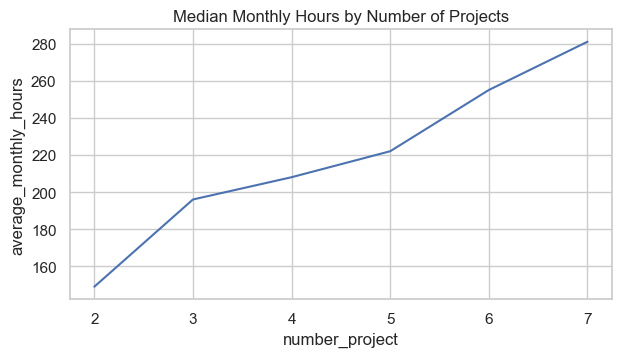

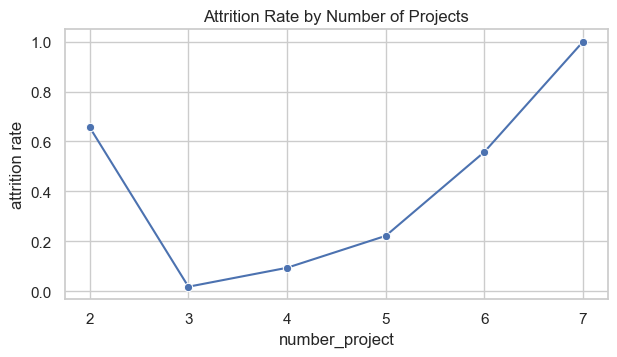

In [14]:
# Workload patterns: Projects vs Monthly Hours
# Helpful for spotting “overloaded” profiles.
proj_hours = df.groupby("number_project")["average_monthly_hours"].agg(["mean", "median", "count"])
display(proj_hours)

plt.figure(figsize=(7, 3.5))
sns.lineplot(data=df, x="number_project", y="average_monthly_hours", estimator="median", errorbar=None)
plt.title("Median Monthly Hours by Number of Projects")
plt.show()

plt.figure(figsize=(7, 3.5))
rate_by_projects = df.groupby("number_project")["left"].mean()
sns.lineplot(x=rate_by_projects.index, y=rate_by_projects.values, marker="o")
plt.title("Attrition Rate by Number of Projects")
plt.xlabel("number_project")
plt.ylabel("attrition rate")
plt.show()
